In [1]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import pyLDAvis
import pyLDAvis.gensim  

import spacy
from spacy.lemmatizer import Lemmatizer
from spacy.lang.en.stop_words import STOP_WORDS

from textblob import TextBlob

from tqdm import tqdm_notebook as tqdm
from pprint import pprint
import warnings
warnings.filterwarnings('ignore')

C:\Users\HP\Anaconda3\lib\site-packages\nltk\decorators.py:68: DeprecationWarning: `formatargspec` is deprecated since Python 3.5. Use `signature` and the `Signature` object directly
  regargs, varargs, varkwargs, defaults, formatvalue=lambda value: ""
C:\Users\HP\Anaconda3\lib\site-packages\nltk\lm\counter.py:15: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sequence, defaultdict


In [2]:
df1 = pd.read_csv('ethiopia_tripadvisor_data_model_3.csv')
df1.head()

,Destination Name,Destination Type,Review Head,Review Body,Review Text,RB_Sentence1,TextBlob Polarity Head,TextBlob Polarity Body,TextBlob Polarity Text,TextBlob Polarity RBS1,RB_Sentence1_Split
0,Rock-Hewn Churches of Lalibela,Landmarks,Incredible locations don't be put off thinking...,Amazing location must visit. This site is mark...,Incredible locations don't be put off thinking...,Amazing location must visit.,-0.05,0.300000,0.125000,0.6000,"['Amazing', 'location', 'must', 'visit.']"
1,Rock-Hewn Churches of Lalibela,Landmarks,It is a real miracle of the world!,I do recommend to visit Lalibela churches and ...,It is a real miracle of the world! I do recomm...,I do recommend to visit Lalibela churches and ...,0.25,-0.150000,-0.016667,0.0000,"['I', 'do', 'recommend', 'to', 'visit', 'Lalib..."
2,Rock-Hewn Churches of Lalibela,Landmarks,Incredible experience,A must visit in Ethiopia - one of the most uni...,Incredible experience A must visit in Ethiopia...,A must visit in Ethiopia - one of the most uni...,0.90,0.345000,0.483750,0.4375,"['A', 'must', 'visit', 'in', 'Ethiopia', '-', ..."
3,Rock-Hewn Churches of Lalibela,Landmarks,Amazing,These churches have to be seen to be believed....,Amazing These churches have to be seen to be b...,These churches have to be seen to be believed.,0.60,0.225000,0.350000,0.0000,"['These', 'churches', 'have', 'to', 'be', 'see..."
4,Rock-Hewn Churches of Lalibela,Landmarks,So much history,Thanks to our tour organiser Ephram who is bas...,So much history Thanks to our tour organiser E...,Thanks to our tour organiser Ephram who is bas...,0.20,0.233333,0.228571,0.2000,"['Thanks', 'to', 'our', 'tour', 'organiser', '..."


In [3]:
df1['RH_Split'] = df1['Review Head'].apply(lambda x: x.split(' '))
df1['RB_Split'] = df1['Review Body'].apply(lambda x: x.split(' '))
df1['RT_Split'] = df1['Review Text'].apply(lambda x: x.split(' '))
df1['RB_Sentence1_Split'] = df1['RB_Sentence1'].apply(lambda x: x.split(' '))
df1.head()

,Destination Name,Destination Type,Review Head,Review Body,Review Text,RB_Sentence1,TextBlob Polarity Head,TextBlob Polarity Body,TextBlob Polarity Text,TextBlob Polarity RBS1,RB_Sentence1_Split,RH_Split,RB_Split,RT_Split
0,Rock-Hewn Churches of Lalibela,Landmarks,Incredible locations don't be put off thinking...,Amazing location must visit. This site is mark...,Incredible locations don't be put off thinking...,Amazing location must visit.,-0.05,0.300000,0.125000,0.6000,"[Amazing, location, must, visit.]","[Incredible, locations, don't, be, put, off, t...","[Amazing, location, must, visit., This, site, ...","[Incredible, locations, don't, be, put, off, t..."
1,Rock-Hewn Churches of Lalibela,Landmarks,It is a real miracle of the world!,I do recommend to visit Lalibela churches and ...,It is a real miracle of the world! I do recomm...,I do recommend to visit Lalibela churches and ...,0.25,-0.150000,-0.016667,0.0000,"[I, do, recommend, to, visit, Lalibela, church...","[It, is, a, real, miracle, of, the, world!]","[I, do, recommend, to, visit, Lalibela, church...","[It, is, a, real, miracle, of, the, world!, I,..."
2,Rock-Hewn Churches of Lalibela,Landmarks,Incredible experience,A must visit in Ethiopia - one of the most uni...,Incredible experience A must visit in Ethiopia...,A must visit in Ethiopia - one of the most uni...,0.90,0.345000,0.483750,0.4375,"[A, must, visit, in, Ethiopia, -, one, of, the...","[Incredible, experience, ]","[A, must, visit, in, Ethiopia, -, one, of, the...","[Incredible, experience, A, must, visit, in, E..."
3,Rock-Hewn Churches of Lalibela,Landmarks,Amazing,These churches have to be seen to be believed....,Amazing These churches have to be seen to be b...,These churches have to be seen to be believed.,0.60,0.225000,0.350000,0.0000,"[These, churches, have, to, be, seen, to, be, ...",[Amazing],"[These, churches, have, to, be, seen, to, be, ...","[Amazing, These, churches, have, to, be, seen,..."
4,Rock-Hewn Churches of Lalibela,Landmarks,So much history,Thanks to our tour organiser Ephram who is bas...,So much history Thanks to our tour organiser E...,Thanks to our tour organiser Ephram who is bas...,0.20,0.233333,0.228571,0.2000,"[Thanks, to, our, tour, organiser, Ephram, who...","[So, much, history]","[Thanks, to, our, tour, organiser, Ephram, who...","[So, much, history, Thanks, to, our, tour, org..."


In [4]:
df1['Destination Type'].value_counts()

Landmarks       3803
Museums         2507
Nature/Parks    2001
Name: Destination Type, dtype: int64

### Topic Modelling

In [5]:
# NLTK Stop words
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

test_subset = df1['RH_Split'].values
sid = SentimentIntensityAnalyzer()
pos_word_list=[]
neu_word_list=[]
neg_word_list=[]

for value in test_subset:
    for word in value:
        if (sid.polarity_scores(word)['compound']) >= 0.4:
            pos_word_list.append(word)
        elif (sid.polarity_scores(word)['compound']) <= -0.4:
            print
            neg_word_list.append(word)
        else:
            neu_word_list.append(word)                

print('Positive :', len(pos_word_list))       
print('Neutral :', len(neu_word_list))    
print('Negative :', len(neg_word_list))

Positive : 4118
Neutral : 35704
Negative : 326


In [6]:
from nltk.corpus import stopwords

main_stop_words = ['ethiopia', 'ethiopian', 'rock', 'hewn', 'church', 'churches', 'park', 'parks', 'museum', 
                       'museums', 'omo', 'valley', 'mountain', 'mountains', 'addis', 'ababa', 'lucy', 'simien', 
                       'national', 'lalibela', 'gelada', 'haile', 'selassie', 'gondar', 'africa' , 'harar', 
                       'cathedral', 'cathedrals', 'place', 'visit', 'girmay', 
                       '\n', '‘s']
positive_stop_words = list(set(pos_word_list))
negative_stop_words = list(set(neg_word_list))
total_stop_words = main_stop_words + positive_stop_words + negative_stop_words

stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])
stop_words.extend(total_stop_words)
print('Stop Words: ', len(stop_words))

Stop Words:  862


In [7]:
# Convert to list
data = df1[df1['Destination Type'] == 'Landmarks'][df1['TextBlob Polarity Head'] < 0]['Review Head'].values.tolist()

# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

pprint(data[:1])

['Incredible locations dont be put off thinking these are boring churches']


In [8]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['incredible', 'locations', 'dont', 'be', 'put', 'off', 'thinking', 'these', 'are', 'boring', 'churches']]


In [9]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['incredible', 'locations', 'dont', 'be', 'put', 'off', 'thinking', 'these', 'are', 'boring', 'churches']


In [10]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [11]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['incredible', 'location', 'put', 'think', 'boring']]


In [12]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1)]]


In [13]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('boring', 1), ('incredible', 1), ('location', 1), ('put', 1), ('think', 1)]]

In [14]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [15]:
# Print the Keyword in the n topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.098*"small" + 0.043*"visit" + 0.028*"work" + 0.017*"quiet" + '
  '0.017*"check" + 0.017*"addition" + 0.017*"compare" + 0.017*"place" + '
  '0.017*"itinerary" + 0.013*"awe"'),
 (1,
  '0.145*"long" + 0.077*"architecture" + 0.069*"drive" + 0.069*"perhaps" + '
  '0.016*"fee" + 0.016*"different" + 0.016*"sure" + 0.016*"make" + '
  '0.009*"flea" + 0.009*"pay"'),
 (2,
  '0.085*"area" + 0.076*"tribe" + 0.076*"meet" + 0.076*"hot" + 0.076*"dusty" + '
  '0.076*"desolate" + 0.059*"hide" + 0.030*"gem" + 0.016*"axum" + '
  '0.016*"keep"'),
 (3,
  '0.197*"worth" + 0.063*"trip" + 0.050*"grave" + 0.050*"religion" + '
  '0.050*"access" + 0.050*"impossible" + 0.047*"see" + 0.026*"expensive" + '
  '0.018*"hidden" + 0.018*"treasure"'),
 (4,
  '0.120*"hour" + 0.052*"site" + 0.029*"difficult" + 0.029*"late" + '
  '0.025*"climb" + 0.021*"careful" + 0.021*"tough" + 0.021*"view" + '
  '0.018*"get" + 0.018*"unique"'),
 (5,
  '0.096*"take" + 0.087*"ground" + 0.081*"common" + 0.081*"find" + 0.081*"art" '

In [16]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.001741146438934

Coherence Score:  0.5549621082070256


In [17]:
# # Visualize the topics
# pyLDAvis.enable_notebook()
# vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
# vis

In [18]:
# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
import os
os.environ.update({'MALLET_HOME':r'C:/Users/HP/mallet-2.0.8/'})
mallet_path = r'C:\Users\HP\mallet-2.0.8\bin\mallet' # update this path
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=10, id2word=id2word, random_seed=1)

In [19]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(0,
  [('history', 0.16666666666666666),
   ('build', 0.08333333333333333),
   ('architecture', 0.05555555555555555),
   ('tough', 0.05555555555555555),
   ('volcanic', 0.05555555555555555),
   ('important', 0.027777777777777776),
   ('unique', 0.027777777777777776),
   ('life', 0.027777777777777776),
   ('unkempt', 0.027777777777777776),
   ('previous', 0.027777777777777776)]),
 (1,
  [('worth', 0.3023255813953488),
   ('trip', 0.09302325581395349),
   ('due', 0.023255813953488372),
   ('itinerary', 0.023255813953488372),
   ('structure', 0.023255813953488372),
   ('totally', 0.023255813953488372),
   ('ground', 0.023255813953488372),
   ('fully', 0.023255813953488372),
   ('recommend', 0.023255813953488372),
   ('describe', 0.023255813953488372)]),
 (2,
  [('treasure', 0.11428571428571428),
   ('gem', 0.08571428571428572),
   ('bustling', 0.02857142857142857),
   ('round', 0.02857142857142857),
   ('manage', 0.02857142857142857),
   ('memorable', 0.02857142857142857),
   ('quaint', 

2
3
4
5
6
7
8
9
10


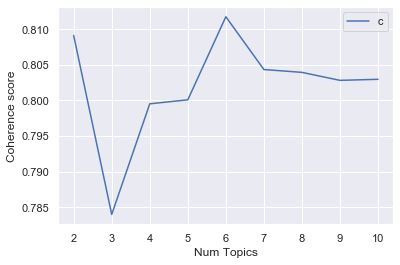

In [20]:
def compute_coherence_values(dictionary, corpus, texts, limit, start, step):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        print(num_topics)
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word,
                                                random_seed=1)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

start1 = 2 
limit1 = 11
step1 = 1

model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=start1, limit=limit1, step=step1)

x = range(start1, limit1, step1)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [21]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.8091
Num Topics = 3  has Coherence Value of 0.784
Num Topics = 4  has Coherence Value of 0.7995
Num Topics = 5  has Coherence Value of 0.8001
Num Topics = 6  has Coherence Value of 0.8118
Num Topics = 7  has Coherence Value of 0.8043
Num Topics = 8  has Coherence Value of 0.8039
Num Topics = 9  has Coherence Value of 0.8028
Num Topics = 10  has Coherence Value of 0.803


In [22]:
optimal_model = model_list[4] # Number of Topics = 6

# optimal_model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=10, id2word=id2word)
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.121*"hide" + 0.106*"orthodox" + 0.106*"history" + 0.091*"time" + '
  '0.061*"close" + 0.015*"documentary" + 0.015*"admission" + 0.015*"important" '
  '+ 0.015*"heavily" + 0.015*"life"'),
 (1,
  '0.183*"worth" + 0.056*"trip" + 0.042*"inside" + 0.028*"money" + '
  '0.028*"overprice" + 0.014*"quaint" + 0.014*"pin" + 0.014*"dark" + '
  '0.014*"rock" + 0.014*"walk"'),
 (2,
  '0.101*"small" + 0.043*"guide" + 0.043*"hidden" + 0.043*"build" + '
  '0.043*"work" + 0.029*"part" + 0.029*"hard" + 0.029*"closed" + 0.029*"gem" + '
  '0.029*"ground"'),
 (3,
  '0.250*"unbelievable" + 0.059*"treasure" + 0.044*"climb" + 0.044*"crazy" + '
  '0.044*"spend" + 0.029*"secret" + 0.015*"discover" + 0.015*"include" + '
  '0.015*"pity" + 0.015*"average"'),
 (4,
  '0.250*"expensive" + 0.047*"difficult" + 0.047*"hour" + 0.047*"long" + '
  '0.031*"volcanic" + 0.031*"religious" + 0.016*"family" + 0.016*"hidden" + '
  '0.016*"ooze" + 0.016*"extreme"'),
 (5,
  '0.083*"site" + 0.083*"experience" + 0.050*"late"

In [23]:
optimal_model2 = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(optimal_model)

# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(optimal_model2, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.181272  0.268816       1        1  16.819038
1      0.076772 -0.340400       2        1  16.719053
4     -0.186712  0.133281       3        1  16.641310
5     -0.192317  0.101778       4        1  16.635835
3      0.309328 -0.017936       5        1  16.616002
0     -0.188342 -0.145540       6        1  16.568762, topic_info=    Category       Freq          Term      Total  loglift  logprob
9    Default  19.000000  unbelievable  19.000000  30.0000  30.0000
17   Default  20.000000     expensive  20.000000  29.0000  29.0000
38   Default  14.000000         worth  14.000000  28.0000  28.0000
25   Default   9.000000          hide   9.000000  27.0000  27.0000
95   Default   8.000000       history   8.000000  26.0000  26.0000
149  Default   8.000000      orthodox   8.000000  25.0000  25.0000
123  Default   8.000000         small   8.000000  24.0000  24.0000
32   Default   7.000000          time   7.000000  23.0000  23.0000
30   Default   6.000000    experience   6.000000  22.0000  22.0000
28   Default   6.000000          site   6.000000  21.0000  21.0000
194  Default   4.000000         close   4.000000  20.0000  20.0000
77   Default   4.000000      treasure   4.000000  19.0000  19.0000
19   Default   4.000000          trip   4.000000  18.0000  18.0000
60   Default   3.000000          late   3.000000  17.0000  17.0000
59   Default   3.000000          hour   3.000000  16.0000  16.0000
117  Default   3.000000     difficult   3.000000  15.0000  15.0000
241  Default   3.000000          long   3.000000  14.0000  14.0000
182  Default   3.000000         climb   3.000000  13.0000  13.0000
210  Default   3.000000         crazy   3.000000  12.0000  12.0000
41   Default   3.000000         spend   3.000000  11.0000  11.0000
15   Default   3.000000          work   3.000000  10.0000  10.0000
79   Default   3.000000         build   3.000000   9.0000   9.0000
22   Default   3.000000         guide   3.000000   8.0000   8.0000
91   Default   3.000000        inside   3.000000   7.0000   7.0000
76   Default   4.000000        hidden   4.000000   6.0000   6.0000
24   Default   4.000000           gem   4.000000   5.0000   5.0000
78   Default   2.000000          miss   2.000000   4.0000   4.0000
5    Default   2.000000           day   2.000000   3.0000   3.0000
83   Default   3.000000         visit   3.000000   2.0000   2.0000
81   Default   2.000000      volcanic   2.000000   1.0000   1.0000
..       ...        ...           ...        ...      ...      ...
70    Topic6   1.179897       heavily   1.179897   1.7977  -4.1897
92    Topic6   1.179897       stretch   1.179897   1.7977  -4.1897
95    Topic6   8.259277       history   8.259277   1.7977  -2.2437
108   Topic6   1.179897        effort   1.179897   1.7977  -4.1897
119   Topic6   1.179897      backdrop   1.179897   1.7977  -4.1897
120   Topic6   1.179897         weird   1.179897   1.7977  -4.1897
127   Topic6   1.179897   documentary   1.179897   1.7977  -4.1897
256   Topic6   1.179897       unkempt   1.179897   1.7977  -4.1897
137   Topic6   1.179897          live   1.179897   1.7977  -4.1897
14    Topic6   1.179897       involve   1.179897   1.7977  -4.1897
213   Topic6   1.179897     structure   1.179897   1.7977  -4.1897
230   Topic6   1.179897    worthwhile   1.179897   1.7977  -4.1897
246   Topic6   1.179897    unsuported   1.179897   1.7977  -4.1897
192   Topic6   1.179897     important   1.179897   1.7977  -4.1897
194   Topic6   4.719587         close   4.719587   1.7977  -2.8034
239   Topic6   1.179897        ghebbi   1.179897   1.7977  -4.1897
204   Topic6   1.179897    accessible   1.179897   1.7977  -4.1897
209   Topic6   1.179897     itinerary   1.179897   1.7977  -4.1897
211   Topic6   1.179897           bit   1.179897   1.7977  -4.1897
149   Topic6   8.259277      orthodox   8.259277   1.7977  -2.2437
220   Topic6   1.179897       totally   1

In [24]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,3.0,0.1749,"unbelievable, treasure, climb, crazy, spend, s...",Incredible locations dont be put off thinking ...
1,1,5.0,0.1795,"site, experience, late, gem, miss, day, visit,...",Poor behavior of guide -- turn off of my day
2,2,2.0,0.1795,"small, guide, hidden, build, work, part, hard,...","900 years active churches, tunel connected"
3,3,3.0,0.1830,"unbelievable, treasure, climb, crazy, spend, s...",Unbelievable
4,4,2.0,0.2040,"small, guide, hidden, build, work, part, hard,...",I cant imagine the hard work involved in carvi...
5,5,3.0,0.1830,"unbelievable, treasure, climb, crazy, spend, s...",Unbelievable
6,6,0.0,0.1667,"hide, orthodox, history, time, close, document...","Churches are interesting but badly kept, dirty..."
7,7,1.0,0.1795,"worth, trip, inside, money, overprice, quaint,...",Expensive trip - don’t need to see 11
8,8,1.0,0.1830,"worth, trip, inside, money, overprice, quaint,...",Unlike any other churches on Earth!
9,9,4.0,0.1808,"expensive, difficult, hour, long, volcanic, re...","Amazing Churches, a little expensive"


In [25]:
df_dominant_topic['Dominant_Topic'].value_counts()

0.0    79
3.0    38
1.0    31
2.0    31
4.0    22
5.0    15
Name: Dominant_Topic, dtype: int64

In [34]:
df_dominant_topic.to_csv('ethiopia_422.csv', index = False)

In [33]:
# import sys
# import numpy
# numpy.set_printoptions(threshold=sys.maxsize)

# Run 2

# df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 0]['Text'].values # Lack of Content - 79
# df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 1]['Text'].values # Expensive Fees - 31
# df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 2]['Text'].values # Describing Smallness - 31
# df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 3]['Text'].values # Topicless/Unidentifiable - 38
# df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 4]['Text'].values # Expensive Fees - 22
# df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 5]['Text'].values # Topicless/Unidentifiable - 15

In [37]:
# import sys
# import numpy
# numpy.set_printoptions(threshold=sys.maxsize)

# Run 1

# df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 0]['Text'].values # Expressing Disappointment - 57
# df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 1]['Text'].values # Describing smallness - 18
# df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 2]['Text'].values # General Criticism - 22
# df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 3]['Text'].values # Expensive Fees - 18
# df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 4]['Text'].values # General Criticism - 14
# df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 5]['Text'].values # Expensive Fees - 22
# df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 6]['Text'].values # General Criticism - 14
# df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 7]['Text'].values # General Criticism - 17
# df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 8]['Text'].values # General Criticism - 11
# df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 9]['Text'].values # General Criticism - 23

In [38]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet.head(10)

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.1987,"hide, orthodox, history, time, close, document...",A must to see once in life-time
1,1.0,0.2058,"worth, trip, inside, money, overprice, quaint,...",Be careful if you suffer from vertigo or are u...
2,2.0,0.2144,"small, guide, hidden, build, work, part, hard,...",Warning: vicious kids throwing rocks off cliff...
3,3.0,0.2050,"unbelievable, treasure, climb, crazy, spend, s...","Weird set up, paying for entrance fee, and mak..."
4,4.0,0.1987,"expensive, difficult, hour, long, volcanic, re...","Expensive, too expensive"
5,5.0,0.2099,"site, experience, late, gem, miss, day, visit,...",Site of the tombs of the late Emperor and his ...


In [39]:
sent_topics_sorteddf_mallet['Text'].values

array(['A must to see once in life-time',
       'Be careful if you suffer from vertigo or are unsteady on your pins',
       'Warning: vicious kids throwing rocks off cliffs at you if you have no guide',
       'Weird set up, paying for entrance fee, and make sure you have flea repellent ready',
       'Expensive, too expensive',
       'Site of the tombs of the late Emperor and his wife'], dtype=object)

In [40]:
# # Number of Documents for Each Topic
# topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# # Percentage of Documents for Each Topic
# topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# # Topic Number and Keywords
# topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# # Concatenate Column wise
# df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# # Change Column names
# df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# # Show
# df_dominant_topics